 # Project 7 - Implémentation d'un Modèle de Scoring
 
## Part 2 of XX - Entraînement des Modèles

# 1. Kaggle Resources

**Data:**
* https://www.kaggle.com/c/home-credit-default-risk/data

**Series of Notebooks detailing the Problem:**
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
* ...

**EDA:**
* https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda

**Feature Engineering:**
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

**Models/Scripts - Light_GBM**
* https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
* https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

**DNN:**
https://www.kaggle.com/shep312/deep-learning-in-tf-with-upsampling-lb-758

# 2. Imports Bibliothèques

In [1]:
import os, re, gc

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
import win32com.client 

In [4]:
import shap
import joblib
import dill

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss, f1_score, balanced_accuracy_score, average_precision_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

# 3. Fonctions

## 3.0 Import des Données

In [8]:
def get_shortcut_path(filepath):
    shell = win32com.client.Dispatch("WScript.Shell")
    shortcut = shell.CreateShortCut(filepath)
    return shortcut.Targetpath +'\\'

## 3.1 Transformers

In [9]:
infinity_transformer = FunctionTransformer(lambda x : x.replace(np.inf, np.nan).replace(-np.inf, np.nan),check_inverse = False)

logscale_transformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = False)
log1pscale_transformer = FunctionTransformer(np.log1p, inverse_func = np.expm1, check_inverse = False)

## 3.2 GridSearch

In [10]:
def gridsearch_evaluation(X_train, y_train, pipeline, param_grid, refit= None, scoring= None, **kwargs) :
    
    grid = GridSearchCV(pipeline, param_grid, refit=refit, scoring=scoring, **kwargs)
                        
    grid.fit(X_train, np.ravel((y_train)))
    
    eval_dict = {}
    test_scoring_dict ={}
    train_scoring_dict = {}
    if refit and scoring:
        for i in scoring :
            test_scoring_dict[i] = (grid.cv_results_["mean_test_" + i][grid.best_index_], 
                                    grid.cv_results_["std_test_" + i][grid.best_index_])
            train_scoring_dict[i] = (grid.cv_results_["mean_train_" + i][grid.best_index_], 
                                     grid.cv_results_["std_train_" + i][grid.best_index_])

        train_time = (grid.cv_results_["mean_fit_time"][grid.best_index_],
                      grid.cv_results_["std_fit_time"][grid.best_index_])

        eval_dict = {'estimator' : grid.best_estimator_,
                     'eval_method' : 'grid',
                     'best_grid_params' : grid.best_params_,
                     'train_scores' : train_scoring_dict, 
                     'test_scores' : test_scoring_dict, 
                     'train_time' : train_time }

    return eval_dict

In [11]:
def output_evaluation(model_name):
    ''' Function that outputs/prints the information from the dictionnary that collects the data from 
    the cross_validate or gridseach'''
    print(f"Model: {model_name}")
    print(50*"_")

    key = model_name
    print()
    print(50*"-")
    if model_dict[key]['eval_method'] == 'grid' :
        print("Les meilleurs parameters sont:")
        print(model_dict[key]['best_grid_params'])
        print()
    for (k1, l1), (k2, l2) in zip(model_dict[key]['train_scores'].items(), model_dict[key]['test_scores'].items()) :
        print(f"Le metric {k1} donne :")
        print(f"{l1[0]: .3f} +/- {l1[1]: .3f} pour le train sets")
        print(f"{l2[0]: .3f} +/- {l2[1]: .3f} pour le test sets")
        print(f"test score / train score :{(l1[0]/l2[0]) : 0.3f}")
        print()
    print(f"Le temps d'entrainement est {(1000 * model_dict[key]['train_time'][0]): .2f} +/-" + \
                                      f"{(1000 * model_dict[key]['train_time'][1]): .2f} ms.")
    print(50*"_")

## 3.3 Métrices, Collection et Affichage de Résultats

In [12]:
scoring_tple = ('neg_log_loss', 'roc_auc', 'average_precision', 'balanced_accuracy', 'f1')

In [88]:
def scores_from_model(model, X_test, y_test, scoring_tple):
    y_test_pred = model.predict_proba(X_test)
    score_dict={}
    for score in scoring_tple:
        if score == 'neg_log_loss':
            score_dict[score] = log_loss(y_test, y_test_pred)
        elif score == 'roc_auc':
            score_dict[score] = roc_auc_score(y_test, y_test_pred[:,1])
        elif score == 'average_precision':
            score_dict[score] = average_precision_score(y_test, y_test_pred[:,1].round())
        elif score == 'balanced_accuracy' :
            score_dict[score] = balanced_accuracy_score(y_test, y_test_pred[:,1].round())
        elif score == 'f1':
            score_dict[score] = f1_score(y_test, y_test_pred[:,1].round())
    return score_dict

In [13]:
model_dict = {}

# 4. Import Données

In [14]:
PATH = os.getcwd()
DATAFOLDER = '\\DataShortcut.lnk'
filepath = get_shortcut_path(PATH+DATAFOLDER)
filename = 'data_processed.csv'

dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

In [15]:
y = dataset['TARGET']
X_id = dataset[['SK_ID_CURR']]
X = dataset.drop(columns=['TARGET', 'SK_ID_CURR'])
del dataset
gc.collect()

0

# 5. Prétraitement

## 5.1 Supprimer des features peu peuplées et corrélées entre eux

Pour les raison de mémoire on a besoin de résuire la taille du modèles. Donc on va supprimer des colonnes/features qui sont probablement pas importantes ou sont rédundantes.

In [16]:
print(f'There are {len(X.columns)} columns per client.')

There are 773 columns per client.


### 5.1.1 Feautres peu peuplées

In [17]:
threshold=0.70
# Identify missing values above a given threshold
X = X.replace(np.inf, np.nan).replace(-np.inf, np.nan)
X_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
X_missing = X_missing.index[X_missing > threshold]
#Drop the sparsely populated features
X = X.drop(columns = X_missing)
print(f'There are {len(X_missing)} columns with more than {100*threshold}% missing values')
print(f'After dropping these columns we are left with {len(X.columns)} columns')

There are 114 columns with more than 70.0% missing values
After dropping these columns we are left with 659 columns


### 5.1.2 Features corrélées

In [18]:
# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

,APPL_NAME_CONTRACT_TYPE,APPL_CODE_GENDER,APPL_FLAG_OWN_CAR,APPL_FLAG_OWN_REALTY,APPL_CNT_CHILDREN,APPL_AMT_INCOME_TOTAL,APPL_AMT_CREDIT,APPL_AMT_ANNUITY,APPL_AMT_GOODS_PRICE,APPL_NAME_EDUCATION_TYPE,...,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,BURO_STATUS_CLOSED_SUM
APPL_NAME_CONTRACT_TYPE,1.000000,0.008741,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.066602,...,0.020268,0.005577,0.005143,0.002233,0.004560,0.000935,0.001790,0.000283,0.006888,0.134229
APPL_CODE_GENDER,0.008741,1.000000,0.345847,0.044371,0.047388,0.074731,0.021594,0.076988,0.022510,0.013343,...,0.071581,0.051681,0.000319,0.003159,0.001273,0.004168,0.004259,0.009504,0.004552,0.010005
APPL_FLAG_OWN_CAR,0.004022,0.345847,1.000000,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.096787,...,0.091050,0.087732,0.012627,0.010495,0.011473,0.001849,0.004293,0.003200,0.006814,0.025824
APPL_FLAG_OWN_REALTY,0.067177,0.044371,0.002817,1.000000,0.002366,0.002934,0.039270,0.005225,0.045537,0.018496,...,0.004036,0.000261,0.003603,0.000538,0.002977,0.001448,0.000805,0.000114,0.007055,0.005356
APPL_CNT_CHILDREN,0.029998,0.047388,0.102023,0.002366,1.000000,0.012882,0.002145,0.021374,0.001827,0.035369,...,0.011064,0.009303,0.005076,0.003553,0.005006,0.000352,0.006179,0.006130,0.000084,0.001094


In [19]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
upper.head()

,APPL_NAME_CONTRACT_TYPE,APPL_CODE_GENDER,APPL_FLAG_OWN_CAR,APPL_FLAG_OWN_REALTY,APPL_CNT_CHILDREN,APPL_AMT_INCOME_TOTAL,APPL_AMT_CREDIT,APPL_AMT_ANNUITY,APPL_AMT_GOODS_PRICE,APPL_NAME_EDUCATION_TYPE,...,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,BURO_STATUS_CLOSED_SUM
APPL_NAME_CONTRACT_TYPE,NaN,0.008741,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.066602,...,0.020268,0.005577,0.005143,0.002233,0.004560,0.000935,0.001790,0.000283,0.006888,0.134229
APPL_CODE_GENDER,NaN,NaN,0.345847,0.044371,0.047388,0.074731,0.021594,0.076988,0.022510,0.013343,...,0.071581,0.051681,0.000319,0.003159,0.001273,0.004168,0.004259,0.009504,0.004552,0.010005
APPL_FLAG_OWN_CAR,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.096787,...,0.091050,0.087732,0.012627,0.010495,0.011473,0.001849,0.004293,0.003200,0.006814,0.025824
APPL_FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,0.018496,...,0.004036,0.000261,0.003603,0.000538,0.002977,0.001448,0.000805,0.000114,0.007055,0.005356
APPL_CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.035369,...,0.011064,0.009303,0.005076,0.003553,0.005006,0.000352,0.006179,0.006130,0.000084,0.001094


In [23]:
# Threshold for removing correlated variables
threshold = 0.90
# Select columns with correlations above threshold
X_correlated = [column for column in upper.columns if any(upper[column] > threshold)]
X = X.drop(columns = X_correlated)
print(f'There are {len(X_correlated)} columns with more than {100*threshold}% correlation')
print(f'After dropping these columns we are left with {len(X.columns)} columns')

There are 138 columns with more than 90.0% correlation
After dropping these columns we are left with 521 columns


### 5.1.3 Résumé des colonnes à suprimmer (+ nettoyage)

In [24]:
X_to_drop = list(X_missing.values) + (X_correlated)

In [25]:
del corr_matrix, upper
gc.collect()

0

## 5.2 Classification des Features en Fonction de leur Distribution

**zero-one-features**
* des valeurs entre 0 et 1

**standard-features**
* des valeurs en dehors de la [0,1] 
* skew < 1
   
**log-features**
* des valeurs > 0
* skew >=1

**log1p-features**
* des valeurs >= 0
* skew >=1

In [26]:
to_be_scaled =  ((X.min() < 0) | (X.max() > 1))
to_be_scaled = [col for col in to_be_scaled[to_be_scaled == True].index.values if col not in X_to_drop]
zero_one_features = [col for col in X.columns if (col not in to_be_scaled) & (col not in X_to_drop)]
print(f"There are {len(zero_one_features)} features that have values  within the range of 0 and 1.\t -> 'zero_one_features'")
print(f"There are {len(to_be_scaled)} features that have values outside the range of 0 and 1.")

There are 273 features that have values  within the range of 0 and 1.	 -> 'zero_one_features'
There are 248 features that have values outside the range of 0 and 1.


In [27]:
#If the skew of the values is greater than 1, we will scale the features with either log or lop1p 
#and if necessary multiply by -1 beforehand
skewed = (X[to_be_scaled].skew() >= 1)
skewed = list(skewed[skewed == True].index.values)
standard_features = [col for col in to_be_scaled if col not in skewed]
print(f"Of the non 'zero_one_features' there are {len(standard_features)} features with skew  < 1.\t -> 'standard_features'")
print(f"Of the non 'zero_one_features' there are {len(skewed)} features with skew >= 1.")

Of the non 'zero_one_features' there are 48 features with skew  < 1.	 -> 'standard_features'
Of the non 'zero_one_features' there are 200 features with skew >= 1.


In [28]:
log_select = (X[skewed].min() > 0)
log_features = list(log_select[log_select == True].index.values)
log1p_select = (X[skewed].min() == 0)
log1p_features = list(log1p_select[log1p_select == True].index.values)
neg_log_select = (X[skewed].max() < 0)
neg_log_features = list(neg_log_select[neg_log_select == True].index.values)
neg_log1p_select = (X[skewed].max() == 0)
neg_log1p_features = list(neg_log1p_select[neg_log1p_select == True].index.values)
print(f"Of the non 'standard_features' there are {len(log_features)} features with min  > 0.\t -> 'log_features'")
print(f"Of the non 'standard_features' there are {len(log1p_features)} features with min == 0.\t -> 'lop1p_features'")
print(f"Of the non 'standard_features' there are {len(neg_log_features)} features with max  < 0.\t -> 'neg_log_features'")
print(f"Of the non 'standard_features' there are {len(neg_log1p_features)} features with max == 0.\t -> 'neg_lop1p_features'")

Of the non 'standard_features' there are 11 features with min  > 0.	 -> 'log_features'
Of the non 'standard_features' there are 171 features with min == 0.	 -> 'lop1p_features'
Of the non 'standard_features' there are 0 features with max  < 0.	 -> 'neg_log_features'
Of the non 'standard_features' there are 0 features with max == 0.	 -> 'neg_lop1p_features'


In [29]:
robustscale_features = [col for col in skewed if col not in log_features+log1p_features]
print(f"There are {len(robustscale_features)} non 'standard_features' that cannot easily \
be transformed to a logscale.\t -> 'robustscale_features'")

There are 18 non 'standard_features' that cannot easily be transformed to a logscale.	 -> 'robustscale_features'


### 5.2.1 APPL_CNT_CHILDREN / APPL_CNT_FAM_MEMBERS

In [30]:
X['APPL_CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: APPL_CNT_CHILDREN, dtype: int64

In [31]:
select = X['APPL_CNT_CHILDREN'] >= 5
X.loc[select, 'APPL_CNT_CHILDREN'] = 5

In [32]:
select = X['APPL_CNT_FAM_MEMBERS'] >= 7
X.loc[select, 'APPL_CNT_FAM_MEMBERS'] = 7

### 5.2.2 One-Hot Features sans beaucoup de variations

In [33]:
threshold = 0.1
X_low_variation = X[zero_one_features].std()[X[zero_one_features].std() < threshold].sort_values().index.values
X_low_variation_y1 = X[y==1][zero_one_features].std()[X[y==1][zero_one_features].std() < 0.15].sort_values().index.values
set(X_low_variation)-set(X_low_variation_y1)

set()

In [34]:
len(X_low_variation)

144

In [35]:
X = X.drop(columns = X_low_variation)
print(f'There are {len(X_low_variation)} zero-one columns with less than {100*threshold}% variation')
print(f'After dropping these columns we are left with {len(X.columns)} columns')

There are 144 zero-one columns with less than 10.0% variation
After dropping these columns we are left with 377 columns


In [111]:
zero_one_features = [col for col in zero_one_features if col not in X_low_variation]

### 5.2.3 Résumé des colonnes à suprimmer (+ nettoyage)

In [36]:
X_to_drop = list(X_missing.values) + (X_correlated) + list(X_low_variation)

In [37]:
del X_low_variation_y1
gc.collect()

0

## 5.3 Export des Features utilisé dans les Modèles

In [38]:
features_for_modeling = [col for col in X.columns if col not in X_to_drop]
len(features_for_modeling)

377

In [39]:
export = True
if export:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    filename = 'features'
    pd.Series(features_for_modeling, name=filename).to_csv(PATH + DATAFOLDER + filename + '.csv')

In [40]:
PATH = os.path.dirname(os.getcwd()) 
DATAFOLDER = '\\Data\\'
filepath = PATH + DATAFOLDER
filename = 'features.csv'
pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

,features
0,APPL_NAME_CONTRACT_TYPE
1,APPL_CODE_GENDER
2,APPL_FLAG_OWN_CAR
3,APPL_FLAG_OWN_REALTY
4,APPL_CNT_CHILDREN
...,...
372,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM
373,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN
374,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM
375,CLOSED_CNT_CREDIT_PROLONG_SUM


# 6. Train/Test Dévision

In [41]:
test_size = 0.3
seed = 33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify=y)

# 7. Les Données Déséquilibrées (test des méthodes)

In [42]:
print(f"{len(X[y==1])} clients in the dataset defaulted, {len(X[y==0])} did not.")
print(f"That's {round(100*len(X[y==1])/len(X), 2)}%.")

24825 clients in the dataset defaulted, 282686 did not.
That's 8.07%.


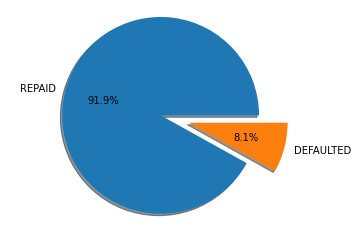

In [43]:
sizes=[len(X[y==0]), len(X[y==1])]
explode = [0, 0.3]
labels = ['REPAID', 'DEFAULTED']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 7.1 Sous-échantillonnage de la classe majoritaire

In [44]:
undersample = True
min_size = len(X_train[y_train==1])
if undersample :
    #undersample manually
    select = list(X_train[y_train==0].sample(min_size, random_state=22).index.values) + list(X_train[y_train==1].index.values)
    X_under = X_train.loc[select, :]
    y_under = y_train.loc[select]
    print(X_train.shape, X_under.shape, y_under.shape, min_size)
    #undersample with the module SMOTE
    rus = RandomUnderSampler(random_state=42)
    X_under, y_under = rus.fit_resample(X_train, y_train)
    print(X_train.shape, X_under.shape, y_under.shape, min_size)

(215257, 377) (34754, 377) (34754,) 17377
(215257, 377) (34754, 377) (34754,) 17377


In [50]:
#clear the memory
#del X_under, y_under
del rus
gc.collect()

0

## 7.2 Suréchantillonnage de la classe minoritaire avec me Module SMOTE

In [45]:
oversample = True
max_size = len(X_train[y_train==0])
if oversample :    
    #oversample with the module SMOTE
    imputer = SimpleImputer()
    X_imp = imputer.fit_transform(X_train)
    smote = SMOTE()
    X_over, y_over = smote.fit_resample(X_imp, y_train)
    print(X_train.shape, X_over.shape, y_over.shape, max_size)

(215257, 377) (395760, 377) (395760,) 197880


In [46]:
#clear the memory
del X_over, y_over, imputer, smote
gc.collect()

0

# 8. Le Préprocesseur (mise à l'échelle des features)

Le préprocesseur est concu d'une telle façon que s'il rencontre des colonnes/features inconnues, il va les simplement écarter (remainder = 'drop').

In [112]:
preprocessor = ColumnTransformer(transformers = [  
                                                 ('zero_one', 'passthrough', zero_one_features),
                                                 ('logscale', Pipeline([('log', logscale_transformer),
                                                                        ('standard', MinMaxScaler())]), 
                                                              log_features),
                                                 ('log1pscale', Pipeline([('log1p', log1pscale_transformer),
                                                                          ('standard', MinMaxScaler())]), 
                                                               log1p_features),
                                                 ('standardscale', MinMaxScaler(), standard_features),
                                                 ('robustscale', MinMaxScaler(), robustscale_features),
                                                         
                                                ], remainder = 'drop')

In [113]:
selectfeatures = ColumnTransformer(transformers = [  
                                                   ('select', 'passthrough', features_for_modeling),
                                                  ], remainder = 'drop')

## 8.1 Export du Preprocesseur

In [114]:
export_model = True
if export_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    joblib.dump(preprocessor, PATH + DATAFOLDER + 'preprocessor')

# 9. Les Modèles

## 9.1 LogisticRegression - Version0

### 9.1.1 Paramètres du Modèle

In [265]:
modelname = 'LogRegr0'

In [266]:
pipeline = Pipeline([
                     #('selectfeatures', selectfeatures),
                     ('preprocessor', MinMaxScaler()),
                     ('imputer', SimpleImputer()),
                     ('model', LogisticRegression(tol=1e-4, max_iter=100, warm_start=True)),
                    ])

In [267]:
param_grid = {'imputer__strategy' : ['median'],
              'model__class_weight' : ['balanced'],
              'model__solver' : ['liblinear'],
              'model__penalty' : ['l2'],
              'model__C' : [2]}

### 9.1.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [268]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.762, test=0.764) balanced_accuracy: (train=0.708, test=0.700) f1: (train=0.708, test=0.701) neg_log_loss: (train=-0.569, test=-0.572) roc_auc: (train=0.776, test=0.773) total time=   5.1s
[CV 2/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.761, test=0.768) balanced_accuracy: (train=0.707, test=0.708) f1: (train=0.707, test=0.709) neg_log_loss: (train=-0.571, test=-0.566) roc_auc: (train=0.775, test=0.779) total time=   5.6s
[CV 3/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.766, test=0.748) balanced_accuracy: (train=0.707, test=0.704) f1: (train=0.707, test=0.703) neg_log_loss: 

In [269]:
model_dict[modelname] = eval_dict

In [270]:
output_evaluation(modelname)

Model: LogRegr0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 2, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.567 +/-  0.002 pour le train sets
-0.579 +/-  0.010 pour le test sets
test score / train score : 0.979

Le metric roc_auc donne :
 0.778 +/-  0.002 pour le train sets
 0.766 +/-  0.009 pour le test sets
test score / train score : 1.015

Le metric average_precision donne :
 0.765 +/-  0.003 pour le train sets
 0.752 +/-  0.013 pour le test sets
test score / train score : 1.018

Le metric balanced_accuracy donne :
 0.708 +/-  0.002 pour le train sets
 0.700 +/-  0.005 pour le test sets
test score / train score : 1.012

Le metric f1 donne :
 0.709 +/-  0.002 pour le train sets
 0.701 +/-  0.005 pour le test sets
test score / train score : 1.011

Le temps d'entrainement est 

In [271]:
estimator = model_dict[modelname]['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[8]


In [272]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5813316466416205
The ROC AUC score for the X_test set is		 0.7646747705694272
The bal. accuracy score for the X_test set is	 0.6994812564940978
The f1 score for the X_test set is		 0.2721134368669818


In [273]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [274]:
gc.collect()

24

#### Evaluation du modèle optimisé avec le X_train

In [275]:
param_grid_best = {'imputer__strategy' : ['median'],
                   'model__class_weight' : ['balanced'],
                   'model__solver' : ['liblinear'],
                   'model__penalty' : ['l2'],
                   'model__C' : [2]}

In [276]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.246, test=0.246) balanced_accuracy: (train=0.705, test=0.702) f1: (train=0.278, test=0.275) neg_log_loss: (train=-0.574, test=-0.576) roc_auc: (train=0.772, test=0.770) total time= 1.2min
[CV 2/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.249, test=0.240) balanced_accuracy: (train=0.704, test=0.701) f1: (train=0.278, test=0.275) neg_log_loss: (train=-0.574, test=-0.577) roc_auc: (train=0.772, test=0.771) total time= 1.2min
[CV 3/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.250, test=0.238) balanced_accuracy: (train=0.705, test=0.699) f1: (train=0.279, test=0.274) neg_log_loss: 

In [277]:
model_dict[modelname+'_Full_Xtrain'] = eval_dict

In [279]:
estimator = model_dict[modelname+'_Full_Xtrain']['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[14]


In [280]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5758731173341154
The ROC AUC score for the X_test set is		 0.7659374315823316
The bal. accuracy score for the X_test set is	 0.7015028430466168
The f1 score for the X_test set is		 0.2753344062475266


In [281]:
model_dict[modelname+'_Full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

### 9.1.3 Résultat

In [78]:
output_evaluation(modelname+'_Full_Xtrain')

Model: LogRegr0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 2, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.573 +/-  0.001 pour le train sets
-0.576 +/-  0.001 pour le test sets
test score / train score : 0.996

Le metric roc_auc donne :
 0.773 +/-  0.001 pour le train sets
 0.767 +/-  0.004 pour le test sets
test score / train score : 1.008

Le metric average_precision donne :
 0.248 +/-  0.002 pour le train sets
 0.242 +/-  0.005 pour le test sets
test score / train score : 1.023

Le metric balanced_accuracy donne :
 0.705 +/-  0.001 pour le train sets
 0.701 +/-  0.002 pour le test sets
test score / train score : 1.006

Le metric f1 donne :
 0.278 +/-  0.001 pour le train sets
 0.275 +/-  0.001 pour le test sets
test score / train score : 1.011

Le temps d'entrainement est 

In [79]:
estimator = model_dict[modelname+'_Full_Xtrain']['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[14]


In [84]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5758731173341154
The ROC AUC score for the X_test set is		 0.7659374315823316
The bal. accuracy score for the X_test set is	 0.7015028430466168
The f1 score for the X_test set is		 0.2753344062475266


In [91]:
model_dict[modelname+'_Full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [93]:
gc.collect()

0

In [92]:
save_notebook = True
if save_notebook :
    dill.dump_session('notebook_P7_02.db')

### 9.1.4 Export du modèle

In [94]:
export_model = True
if export_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    #estimator.fit(X, y)
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

### 9.1.5 Re-Import du Modèle

In [ ]:
import_model = False
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    modelname = 'LogRegr0'
    estimator = joblib.load(PATH + DATAFOLDER + modelname)

## 9.2 LogisticRegression - Version1 (avec SMOTE)

### 9.2.1 Paramètres du Modèle

In [95]:
modelname = 'LogRegr1'

In [96]:
pipeline = Pipeline([('preprocessor', MinMaxScaler()),
                     ('imputer', SimpleImputer()),
                     ('smote', SMOTE()),
                     ('model', LogisticRegression(tol=1e-4, warm_start=True))
                    ])

In [97]:
param_grid = {'imputer__strategy' : ['median'],
              'model__solver' : ['liblinear'],
              'model__penalty' : ['l2'],
              'model__C' : [2]}

### 9.2.2 GridSearch

In [98]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=2, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.235, test=0.235) balanced_accuracy: (train=0.693, test=0.692) f1: (train=0.273, test=0.272) neg_log_loss: (train=-0.559, test=-0.561) roc_auc: (train=0.759, test=0.758) total time= 2.2min
[CV 2/5] END imputer__strategy=median, model__C=2, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.238, test=0.230) balanced_accuracy: (train=0.693, test=0.694) f1: (train=0.274, test=0.274) neg_log_loss: (train=-0.558, test=-0.560) roc_auc: (train=0.759, test=0.759) total time= 2.0min
[CV 3/5] END imputer__strategy=median, model__C=2, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.238, test=0.227) balanced_accuracy: (train=0.695, test=0.689) f1: (train=0.275, test=0.271) neg_log_loss: (train=-0.557, test=-0.560) roc_auc: (train=0.760, test=0.754) total time= 2.1min
[CV 4/5]

In [99]:
model_dict[modelname] = eval_dict

### 9.2.3 Résultat

In [100]:
output_evaluation(modelname)

Model: LogRegr1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 2, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.558 +/-  0.001 pour le train sets
-0.560 +/-  0.000 pour le test sets
test score / train score : 0.995

Le metric roc_auc donne :
 0.760 +/-  0.001 pour le train sets
 0.754 +/-  0.004 pour le test sets
test score / train score : 1.008

Le metric average_precision donne :
 0.237 +/-  0.002 pour le train sets
 0.231 +/-  0.004 pour le test sets
test score / train score : 1.025

Le metric balanced_accuracy donne :
 0.694 +/-  0.001 pour le train sets
 0.689 +/-  0.003 pour le test sets
test score / train score : 1.006

Le metric f1 donne :
 0.274 +/-  0.001 pour le train sets
 0.271 +/-  0.002 pour le test sets
test score / train score : 1.012

Le temps d'entrainement est  121199.68 +/- 5404.84 ms.
________

In [101]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [102]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5619806408269087
The ROC AUC score for the X_test set is		 0.7524151603180094
The bal. accuracy score for the X_test set is	 0.6883993246429654
The f1 score for the X_test set is		 0.2696334362955471


In [103]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [104]:
gc.collect()

24

In [105]:
save_notebook = True
if save_notebook :
    dill.dump_session('notebook_P7_02.db')

### 9.2.4 Export du modèle

In [106]:
export_model = True
if export_model: 
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    #estimator.fit(X, y)
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

## 9.3 LogisticRegression - Version2 (avec un preprocessor customisé)

### 9.3.1 Paramètres du Modèle

In [282]:
modelname = 'LogRegr2'

In [283]:
pipeline = Pipeline([
                     ('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('model', LogisticRegression(tol=1e-4, max_iter=500, warm_start=True))
                    ])

In [284]:
param_grid = {'imputer__strategy' : ['median'],
              'model__class_weight' : ['balanced'],
              'model__solver' : ['liblinear'],
              'model__penalty' :['l2'],
              'model__C' : [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]}

### 9.3.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [285]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.755, test=0.762) balanced_accuracy: (train=0.700, test=0.700) f1: (train=0.700, test=0.700) neg_log_loss: (train=-0.580, test=-0.577) roc_auc: (train=0.768, test=0.771) total time=   2.1s
[CV 2/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.752, test=0.770) balanced_accuracy: (train=0.700, test=0.704) f1: (train=0.699, test=0.702) neg_log_loss: (train=-0.582, test=-0.573) roc_auc: (train=0.767, test=0.776) total time=   2.2s
[CV 3/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.757, test=0.749) balanced_accuracy: (train=0.700, test=0.703) f1: (train=0.700, test=0.702) neg_

[CV 5/5] END imputer__strategy=median, model__C=1, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.772, test=0.748) balanced_accuracy: (train=0.713, test=0.690) f1: (train=0.712, test=0.693) neg_log_loss: (train=-0.562, test=-0.585) roc_auc: (train=0.784, test=0.759) total time=   4.7s
[CV 1/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.767, test=0.767) balanced_accuracy: (train=0.712, test=0.703) f1: (train=0.713, test=0.705) neg_log_loss: (train=-0.565, test=-0.570) roc_auc: (train=0.780, test=0.775) total time=   4.9s
[CV 2/5] END imputer__strategy=median, model__C=2, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.766, test=0.773) balanced_accuracy: (train=0.709, test=0.710) f1: (train=0.708, test=0.709) neg_log_loss: (train=-0.567, test=-0.563) roc_auc: (train=0.778, test=0.7

In [286]:
model_dict[modelname] = eval_dict

In [287]:
output_evaluation(modelname)

Model: LogRegr2
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.5, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.564 +/-  0.002 pour le train sets
-0.576 +/-  0.010 pour le test sets
test score / train score : 0.981

Le metric roc_auc donne :
 0.781 +/-  0.002 pour le train sets
 0.770 +/-  0.009 pour le test sets
test score / train score : 1.014

Le metric average_precision donne :
 0.769 +/-  0.003 pour le train sets
 0.757 +/-  0.012 pour le test sets
test score / train score : 1.016

Le metric balanced_accuracy donne :
 0.710 +/-  0.002 pour le train sets
 0.701 +/-  0.008 pour le test sets
test score / train score : 1.013

Le metric f1 donne :
 0.710 +/-  0.002 pour le train sets
 0.702 +/-  0.007 pour le test sets
test score / train score : 1.013

Le temps d'entrainement es

In [288]:
estimator = model_dict[modelname]['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[5]


In [289]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5777595943674396
The ROC AUC score for the X_test set is		 0.7673889817216741
The bal. accuracy score for the X_test set is	 0.7017670905578317
The f1 score for the X_test set is		 0.274623740348122


In [290]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [291]:
gc.collect()

397

#### Evaluation du modèle optimisé avec le X_train

In [292]:
param_grid_best = {'imputer__strategy' : ['median'],
                   'model__class_weight' : ['balanced'],
                   'model__solver' : ['liblinear'],
                   'model__penalty' : ['l2'],
                   'model__C' : [0.5]}

In [293]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=0.5, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.252, test=0.253) balanced_accuracy: (train=0.708, test=0.704) f1: (train=0.281, test=0.278) neg_log_loss: (train=-0.571, test=-0.572) roc_auc: (train=0.776, test=0.774) total time=  44.3s
[CV 2/5] END imputer__strategy=median, model__C=0.5, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.256, test=0.245) balanced_accuracy: (train=0.707, test=0.704) f1: (train=0.280, test=0.278) neg_log_loss: (train=-0.571, test=-0.572) roc_auc: (train=0.776, test=0.774) total time=  45.3s
[CV 3/5] END imputer__strategy=median, model__C=0.5, model__class_weight=balanced, model__penalty=l2, model__solver=liblinear; average_precision: (train=0.255, test=0.248) balanced_accuracy: (train=0.707, test=0.703) f1: (train=0.280, test=0.277) neg_log_

In [294]:
model_dict[modelname+'_Full_Xtrain'] = eval_dict

In [295]:
output_evaluation(modelname+'_Full_Xtrain')

Model: LogRegr2_Full_Xtrain
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.5, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.570 +/-  0.001 pour le train sets
-0.572 +/-  0.002 pour le test sets
test score / train score : 0.997

Le metric roc_auc donne :
 0.777 +/-  0.001 pour le train sets
 0.770 +/-  0.003 pour le test sets
test score / train score : 1.008

Le metric average_precision donne :
 0.254 +/-  0.001 pour le train sets
 0.249 +/-  0.004 pour le test sets
test score / train score : 1.023

Le metric balanced_accuracy donne :
 0.708 +/-  0.000 pour le train sets
 0.703 +/-  0.002 pour le test sets
test score / train score : 1.007

Le metric f1 donne :
 0.281 +/-  0.000 pour le train sets
 0.277 +/-  0.001 pour le test sets
test score / train score : 1.013

Le temps d'ent

In [296]:
estimator = model_dict[modelname+'_Full_Xtrain']['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[8]


In [297]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.572294751659219
The ROC AUC score for the X_test set is		 0.7694460666187689
The bal. accuracy score for the X_test set is	 0.701206575464978
The f1 score for the X_test set is		 0.27537879789512654


In [298]:
model_dict[modelname+'_Full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [299]:
gc.collect()

336

### 9.3.3 Résultat 

In [126]:
output_evaluation(modelname+'_Full_Xtrain')

Model: LogRegr2
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.5, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Le metric neg_log_loss donne :
-0.570 +/-  0.001 pour le train sets
-0.572 +/-  0.002 pour le test sets
test score / train score : 0.997

Le metric roc_auc donne :
 0.777 +/-  0.001 pour le train sets
 0.770 +/-  0.003 pour le test sets
test score / train score : 1.008

Le metric average_precision donne :
 0.254 +/-  0.001 pour le train sets
 0.249 +/-  0.004 pour le test sets
test score / train score : 1.023

Le metric balanced_accuracy donne :
 0.708 +/-  0.000 pour le train sets
 0.703 +/-  0.002 pour le test sets
test score / train score : 1.007

Le metric f1 donne :
 0.281 +/-  0.000 pour le train sets
 0.277 +/-  0.001 pour le test sets
test score / train score : 1.013

Le temps d'entrainement es

In [127]:
estimator = model_dict[modelname+'_Full_Xtrain']['estimator']
print(estimator.named_steps.model.n_iter_)
y_test_pred = estimator.predict_proba(X_test)

[8]


In [128]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.572294751659219
The ROC AUC score for the X_test set is		 0.7694460666187689
The bal. accuracy score for the X_test set is	 0.701206575464978
The f1 score for the X_test set is		 0.27537879789512654


In [129]:
model_dict[modelname+'_Full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [130]:
gc.collect()

48

In [300]:
save_notebook = True
if save_notebook :
    dill.dump_session('notebook_P7_02.db')

### 9.3.4 Export du modèle

In [132]:
export_model = True
if export_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    estimator = model_dict[modelname]['estimator']
    #estimator.fit(X, y)
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

In [133]:
gc.collect()

0

## 9.4 LogisticRegression - Version3 (avec preprocessor customisé et PCA)

### 9.4.1 Paramètres du Modèle

In [120]:
modelname = 'LogRegr3'

In [121]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('imputer', SimpleImputer()),
                     ('pca', PCA(0.99)),
                     ('model', LogisticRegression(tol=1e-4, warm_start=True))
                    ])

In [124]:
param_grid = {'imputer__strategy' : ['median'],
              'pca__n_components' : [0.95, 0.98, 0.99],
              'model__class_weight' : ['balanced'],
              'model__solver' : ['liblinear'],
              'model__C' : [0.01, 0.05, 0.1, 0.2, 0.5]}


### 9.4.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [125]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.95; balanced_accuracy: (train=0.699, test=0.699) f1: (train=0.699, test=0.699) neg_log_loss: (train=-0.581, test=-0.578) roc_auc: (train=0.766, test=0.770) total time=   5.0s
[CV 2/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.95; balanced_accuracy: (train=0.698, test=0.703) f1: (train=0.697, test=0.701) neg_log_loss: (train=-0.583, test=-0.574) roc_auc: (train=0.765, test=0.775) total time=   4.6s
[CV 3/5] END imputer__strategy=median, model__C=0.01, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.95; balanced_accuracy: (train=0.698, test=0.701) f1: (train=0.697, test=0.700) neg_log_loss: (train=-0.580, test=-0.583) roc_auc: (train=0.767, test=0.765) total time=   4.8s
[CV 4/5] END imputer__strat

[CV 3/5] END imputer__strategy=median, model__C=0.05, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.705, test=0.706) f1: (train=0.705, test=0.704) neg_log_loss: (train=-0.569, test=-0.575) roc_auc: (train=0.776, test=0.771) total time=   5.4s
[CV 4/5] END imputer__strategy=median, model__C=0.05, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.709, test=0.692) f1: (train=0.709, test=0.691) neg_log_loss: (train=-0.566, test=-0.587) roc_auc: (train=0.779, test=0.757) total time=   5.4s
[CV 5/5] END imputer__strategy=median, model__C=0.05, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.709, test=0.690) f1: (train=0.709, test=0.694) neg_log_loss: (train=-0.566, test=-0.586) roc_auc: (train=0.780, test=0.757) total time=   5.4s
[CV 1/5] END imputer__strategy=median, model__C=0.1, model__class_weight=balanced, model

[CV 1/5] END imputer__strategy=median, model__C=0.2, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.708, test=0.701) f1: (train=0.709, test=0.703) neg_log_loss: (train=-0.568, test=-0.569) roc_auc: (train=0.777, test=0.774) total time=   5.7s
[CV 2/5] END imputer__strategy=median, model__C=0.2, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.705, test=0.714) f1: (train=0.705, test=0.712) neg_log_loss: (train=-0.570, test=-0.564) roc_auc: (train=0.775, test=0.780) total time=   5.8s
[CV 3/5] END imputer__strategy=median, model__C=0.2, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.707, test=0.707) f1: (train=0.707, test=0.705) neg_log_loss: (train=-0.567, test=-0.575) roc_auc: (train=0.777, test=0.771) total time=   6.2s
[CV 4/5] END imputer__strategy=median, model__C=0.2, model__class_weight=balanced, model__s

In [126]:
model_dict[modelname] = eval_dict

In [127]:
output_evaluation(modelname)

Model: LogRegr3
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'liblinear', 'pca__n_components': 0.99}

Le metric neg_log_loss donne :
-0.57 +/-  0.00 pour le train sets
-0.58 +/-  0.01 pour le test sets
test score / train score : 0.98

Le metric roc_auc donne :
 0.78 +/-  0.00 pour le train sets
 0.77 +/-  0.01 pour le test sets
test score / train score : 1.01

Le metric balanced_accuracy donne :
 0.71 +/-  0.00 pour le train sets
 0.70 +/-  0.01 pour le test sets
test score / train score : 1.01

Le metric f1 donne :
 0.71 +/-  0.00 pour le train sets
 0.70 +/-  0.01 pour le test sets
test score / train score : 1.01

Le temps d'entrainement est  5235.92 +/- 31.88 ms.
__________________________________________________


In [128]:
gc.collect()

839

#### Evaluation du modèle optimisé avec le X_train

In [129]:
param_grid_best = {'imputer__strategy' : ['median'],
                   'pca__n_components' : [0.99],
                   'model__class_weight' : ['balanced'],
                   'model__solver' : ['liblinear'],
                   'model__C' : [0.1]}

In [130]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__C=0.1, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.705, test=0.701) f1: (train=0.278, test=0.275) neg_log_loss: (train=-0.573, test=-0.574) roc_auc: (train=0.773, test=0.773) total time=  46.1s
[CV 2/5] END imputer__strategy=median, model__C=0.1, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.705, test=0.702) f1: (train=0.278, test=0.276) neg_log_loss: (train=-0.573, test=-0.575) roc_auc: (train=0.773, test=0.770) total time=  45.4s
[CV 3/5] END imputer__strategy=median, model__C=0.1, model__class_weight=balanced, model__solver=liblinear, pca__n_components=0.99; balanced_accuracy: (train=0.704, test=0.701) f1: (train=0.278, test=0.275) neg_log_loss: (train=-0.573, test=-0.575) roc_auc: (train=0.774, test=0.768) total time=  45.1s
[CV 4/5] END imputer__strategy=m

In [131]:
model_dict[modelname] = eval_dict

### 9.4.3 Résultat

In [132]:
output_evaluation(modelname)

Model: LogRegr3
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'liblinear', 'pca__n_components': 0.99}

Le metric neg_log_loss donne :
-0.57 +/-  0.00 pour le train sets
-0.57 +/-  0.00 pour le test sets
test score / train score : 1.00

Le metric roc_auc donne :
 0.77 +/-  0.00 pour le train sets
 0.77 +/-  0.00 pour le test sets
test score / train score : 1.01

Le metric balanced_accuracy donne :
 0.70 +/-  0.00 pour le train sets
 0.70 +/-  0.00 pour le test sets
test score / train score : 1.01

Le metric f1 donne :
 0.28 +/-  0.00 pour le train sets
 0.27 +/-  0.00 pour le test sets
test score / train score : 1.01

Le temps d'entrainement est  42666.80 +/- 395.36 ms.
__________________________________________________


In [133]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [134]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5742882177095737
The ROC AUC score for the X_test set is		 0.767634259419103
The bal. accuracy score for the X_test set is	 0.7011563296812922
The f1 score for the X_test set is		 0.2749822073437541


In [136]:
gc.collect()

312

## 9.5 BalancedRandomForestClassifier (sans préprocessor) - Vérsion0

### 9.5.1 Paramètres du Modèle

In [164]:
modelname = 'BalRandForest0'

In [165]:
pipeline = Pipeline([
                     ('imputer', SimpleImputer(strategy='median')),
                     ('model', BalancedRandomForestClassifier(random_state=33, verbose=1))
                    ])

In [166]:
param_grid = {'model__class_weight' : ['balanced'],
              'model__max_depth' :[2, 5, 10, 20],
              'model__n_estimators' : [50, 100, 150]}

### 9.5.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [167]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=50; average_precision: (train=0.702, test=0.705) balanced_accuracy: (train=0.655, test=0.652) f1: (train=0.661, test=0.656) neg_log_loss: (train=-0.662, test=-0.662) roc_auc: (train=0.715, test=0.712) total time=   4.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=50; average_precision: (train=0.701, test=0.728) balanced_accuracy: (train=0.656, test=0.667) f1: (train=0.658, test=0.668) neg_log_loss: (train=-0.663, test=-0.660) roc_auc: (train=0.715, test=0.732) total time=   4.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=50; average_precision: (train=0.703, test=0.701) balanced_accuracy: (train=0.652, test=0.657) f1: (train=0.656, test=0.660) neg_log_loss: (train=-0.662, test=-0.662) roc_auc: (train=0.713, test=0.715) total time=   4.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=50; average_precision: (train=0.709, test=0.677) balanced_accuracy: (train=0.659, test=0.640) f1: (train=0.663, test=0.645) neg_log_loss: (train=-0.660, test=-0.664) roc_auc: (train=0.719, test=0.696) total time=   4.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=50; average_precision: (train=0.705, test=0.678) balanced_accuracy: (train=0.654, test=0.641) f1: (train=0.660, test=0.650) neg_log_loss: (train=-0.661, test=-0.664) roc_auc: (train=0.715, test=0.693) total time=   4.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=100; average_precision: (train=0.703, test=0.707) balanced_accuracy: (train=0.655, test=0.654) f1: (train=0.662, test=0.658) neg_log_loss: (train=-0.662, test=-0.663) roc_auc: (train=0.715, test=0.713) total time=   8.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=100; average_precision: (train=0.703, test=0.731) balanced_accuracy: (train=0.657, test=0.668) f1: (train=0.661, test=0.670) neg_log_loss: (train=-0.663, test=-0.660) roc_auc: (train=0.718, test=0.734) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=100; average_precision: (train=0.706, test=0.703) balanced_accuracy: (train=0.656, test=0.660) f1: (train=0.659, test=0.662) neg_log_loss: (train=-0.663, test=-0.663) roc_auc: (train=0.716, test=0.718) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=100; average_precision: (train=0.713, test=0.680) balanced_accuracy: (train=0.661, test=0.644) f1: (train=0.665, test=0.650) neg_log_loss: (train=-0.661, test=-0.665) roc_auc: (train=0.723, test=0.700) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=100; average_precision: (train=0.706, test=0.679) balanced_accuracy: (train=0.656, test=0.644) f1: (train=0.660, test=0.652) neg_log_loss: (train=-0.661, test=-0.665) roc_auc: (train=0.717, test=0.693) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=150; average_precision: (train=0.702, test=0.705) balanced_accuracy: (train=0.652, test=0.649) f1: (train=0.660, test=0.654) neg_log_loss: (train=-0.663, test=-0.663) roc_auc: (train=0.712, test=0.709) total time=  13.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=150; average_precision: (train=0.702, test=0.730) balanced_accuracy: (train=0.656, test=0.666) f1: (train=0.661, test=0.668) neg_log_loss: (train=-0.664, test=-0.661) roc_auc: (train=0.715, test=0.732) total time=  12.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=150; average_precision: (train=0.704, test=0.702) balanced_accuracy: (train=0.653, test=0.657) f1: (train=0.657, test=0.660) neg_log_loss: (train=-0.663, test=-0.663) roc_auc: (train=0.713, test=0.715) total time=  12.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=150; average_precision: (train=0.713, test=0.681) balanced_accuracy: (train=0.660, test=0.642) f1: (train=0.664, test=0.648) neg_log_loss: (train=-0.662, test=-0.665) roc_auc: (train=0.721, test=0.699) total time=  12.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=2, model__n_estimators=150; average_precision: (train=0.704, test=0.678) balanced_accuracy: (train=0.653, test=0.638) f1: (train=0.659, test=0.646) neg_log_loss: (train=-0.662, test=-0.666) roc_auc: (train=0.714, test=0.690) total time=  12.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=50; average_precision: (train=0.743, test=0.730) balanced_accuracy: (train=0.690, test=0.681) f1: (train=0.693, test=0.684) neg_log_loss: (train=-0.627, test=-0.633) roc_auc: (train=0.755, test=0.738) total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=50; average_precision: (train=0.745, test=0.749) balanced_accuracy: (train=0.692, test=0.688) f1: (train=0.695, test=0.687) neg_log_loss: (train=-0.628, test=-0.629) roc_auc: (train=0.757, test=0.755) total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=50; average_precision: (train=0.747, test=0.726) balanced_accuracy: (train=0.691, test=0.685) f1: (train=0.690, test=0.684) neg_log_loss: (train=-0.627, test=-0.633) roc_auc: (train=0.758, test=0.740) total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=50; average_precision: (train=0.752, test=0.703) balanced_accuracy: (train=0.696, test=0.661) f1: (train=0.696, test=0.661) neg_log_loss: (train=-0.623, test=-0.638) roc_auc: (train=0.762, test=0.720) total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=50; average_precision: (train=0.746, test=0.704) balanced_accuracy: (train=0.690, test=0.661) f1: (train=0.694, test=0.668) neg_log_loss: (train=-0.624, test=-0.638) roc_auc: (train=0.757, test=0.719) total time=   6.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=100; average_precision: (train=0.746, test=0.732) balanced_accuracy: (train=0.691, test=0.680) f1: (train=0.694, test=0.684) neg_log_loss: (train=-0.628, test=-0.634) roc_auc: (train=0.757, test=0.738) total time=  11.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=100; average_precision: (train=0.745, test=0.751) balanced_accuracy: (train=0.693, test=0.689) f1: (train=0.696, test=0.687) neg_log_loss: (train=-0.629, test=-0.630) roc_auc: (train=0.759, test=0.756) total time=  11.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=100; average_precision: (train=0.750, test=0.726) balanced_accuracy: (train=0.692, test=0.682) f1: (train=0.692, test=0.680) neg_log_loss: (train=-0.628, test=-0.634) roc_auc: (train=0.760, test=0.741) total time=  11.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=100; average_precision: (train=0.754, test=0.704) balanced_accuracy: (train=0.696, test=0.662) f1: (train=0.697, test=0.664) neg_log_loss: (train=-0.624, test=-0.639) roc_auc: (train=0.763, test=0.723) total time=  11.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=100; average_precision: (train=0.750, test=0.707) balanced_accuracy: (train=0.691, test=0.663) f1: (train=0.694, test=0.669) neg_log_loss: (train=-0.625, test=-0.639) roc_auc: (train=0.760, test=0.720) total time=  11.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.747, test=0.730) balanced_accuracy: (train=0.690, test=0.678) f1: (train=0.695, test=0.683) neg_log_loss: (train=-0.629, test=-0.635) roc_auc: (train=0.757, test=0.737) total time=  17.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.747, test=0.752) balanced_accuracy: (train=0.692, test=0.689) f1: (train=0.695, test=0.689) neg_log_loss: (train=-0.629, test=-0.630) roc_auc: (train=0.759, test=0.756) total time=  17.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.750, test=0.726) balanced_accuracy: (train=0.693, test=0.680) f1: (train=0.693, test=0.678) neg_log_loss: (train=-0.628, test=-0.634) roc_auc: (train=0.760, test=0.741) total time=  17.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.754, test=0.704) balanced_accuracy: (train=0.697, test=0.658) f1: (train=0.698, test=0.662) neg_log_loss: (train=-0.625, test=-0.639) roc_auc: (train=0.763, test=0.722) total time=  17.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.750, test=0.708) balanced_accuracy: (train=0.692, test=0.665) f1: (train=0.695, test=0.672) neg_log_loss: (train=-0.626, test=-0.639) roc_auc: (train=0.760, test=0.722) total time=  17.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=50; average_precision: (train=0.907, test=0.737) balanced_accuracy: (train=0.826, test=0.686) f1: (train=0.827, test=0.688) neg_log_loss: (train=-0.515, test=-0.610) roc_auc: (train=0.907, test=0.749) total time=   8.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=50; average_precision: (train=0.906, test=0.754) balanced_accuracy: (train=0.827, test=0.697) f1: (train=0.829, test=0.694) neg_log_loss: (train=-0.517, test=-0.605) roc_auc: (train=0.907, test=0.762) total time=   8.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=50; average_precision: (train=0.907, test=0.736) balanced_accuracy: (train=0.826, test=0.693) f1: (train=0.826, test=0.693) neg_log_loss: (train=-0.516, test=-0.608) roc_auc: (train=0.907, test=0.754) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=50; average_precision: (train=0.906, test=0.712) balanced_accuracy: (train=0.828, test=0.667) f1: (train=0.829, test=0.667) neg_log_loss: (train=-0.511, test=-0.618) roc_auc: (train=0.908, test=0.731) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=50; average_precision: (train=0.907, test=0.726) balanced_accuracy: (train=0.826, test=0.679) f1: (train=0.827, test=0.683) neg_log_loss: (train=-0.513, test=-0.614) roc_auc: (train=0.908, test=0.739) total time=   8.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=100; average_precision: (train=0.911, test=0.741) balanced_accuracy: (train=0.829, test=0.691) f1: (train=0.831, test=0.694) neg_log_loss: (train=-0.514, test=-0.609) roc_auc: (train=0.911, test=0.752) total time=  16.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=100; average_precision: (train=0.911, test=0.760) balanced_accuracy: (train=0.831, test=0.702) f1: (train=0.833, test=0.699) neg_log_loss: (train=-0.516, test=-0.604) roc_auc: (train=0.912, test=0.766) total time=  16.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=100; average_precision: (train=0.911, test=0.740) balanced_accuracy: (train=0.831, test=0.698) f1: (train=0.831, test=0.698) neg_log_loss: (train=-0.515, test=-0.607) roc_auc: (train=0.911, test=0.759) total time=  18.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=100; average_precision: (train=0.912, test=0.719) balanced_accuracy: (train=0.834, test=0.672) f1: (train=0.835, test=0.673) neg_log_loss: (train=-0.509, test=-0.616) roc_auc: (train=0.913, test=0.736) total time=  16.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=100; average_precision: (train=0.911, test=0.725) balanced_accuracy: (train=0.833, test=0.680) f1: (train=0.834, test=0.684) neg_log_loss: (train=-0.511, test=-0.615) roc_auc: (train=0.912, test=0.740) total time=  16.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.912, test=0.743) balanced_accuracy: (train=0.830, test=0.690) f1: (train=0.831, test=0.693) neg_log_loss: (train=-0.514, test=-0.609) roc_auc: (train=0.912, test=0.753) total time=  24.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.912, test=0.761) balanced_accuracy: (train=0.832, test=0.700) f1: (train=0.833, test=0.697) neg_log_loss: (train=-0.516, test=-0.603) roc_auc: (train=0.913, test=0.768) total time=  24.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.913, test=0.743) balanced_accuracy: (train=0.834, test=0.698) f1: (train=0.834, test=0.697) neg_log_loss: (train=-0.514, test=-0.607) roc_auc: (train=0.913, test=0.759) total time=  24.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.915, test=0.721) balanced_accuracy: (train=0.835, test=0.675) f1: (train=0.835, test=0.675) neg_log_loss: (train=-0.509, test=-0.616) roc_auc: (train=0.915, test=0.738) total time=  24.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.913, test=0.725) balanced_accuracy: (train=0.835, test=0.680) f1: (train=0.836, test=0.684) neg_log_loss: (train=-0.511, test=-0.615) roc_auc: (train=0.914, test=0.740) total time=  26.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=50; average_precision: (train=1.000, test=0.729) balanced_accuracy: (train=0.996, test=0.678) f1: (train=0.996, test=0.679) neg_log_loss: (train=-0.224, test=-0.605) roc_auc: (train=1.000, test=0.742) total time=  12.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=50; average_precision: (train=1.000, test=0.750) balanced_accuracy: (train=0.996, test=0.690) f1: (train=0.996, test=0.688) neg_log_loss: (train=-0.223, test=-0.595) roc_auc: (train=1.000, test=0.758) total time=  11.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=50; average_precision: (train=1.000, test=0.734) balanced_accuracy: (train=0.997, test=0.685) f1: (train=0.997, test=0.686) neg_log_loss: (train=-0.222, test=-0.600) roc_auc: (train=1.000, test=0.749) total time=  11.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=50; average_precision: (train=1.000, test=0.706) balanced_accuracy: (train=0.996, test=0.666) f1: (train=0.996, test=0.669) neg_log_loss: (train=-0.220, test=-0.614) roc_auc: (train=1.000, test=0.728) total time=  11.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=50; average_precision: (train=1.000, test=0.710) balanced_accuracy: (train=0.996, test=0.673) f1: (train=0.996, test=0.677) neg_log_loss: (train=-0.220, test=-0.613) roc_auc: (train=1.000, test=0.729) total time=  11.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=100; average_precision: (train=1.000, test=0.741) balanced_accuracy: (train=0.997, test=0.690) f1: (train=0.997, test=0.691) neg_log_loss: (train=-0.222, test=-0.599) roc_auc: (train=1.000, test=0.754) total time=  22.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=100; average_precision: (train=1.000, test=0.757) balanced_accuracy: (train=0.997, test=0.700) f1: (train=0.997, test=0.696) neg_log_loss: (train=-0.221, test=-0.594) roc_auc: (train=1.000, test=0.766) total time=  22.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=100; average_precision: (train=1.000, test=0.741) balanced_accuracy: (train=0.998, test=0.694) f1: (train=0.998, test=0.694) neg_log_loss: (train=-0.221, test=-0.598) roc_auc: (train=1.000, test=0.758) total time=  22.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=100; average_precision: (train=1.000, test=0.717) balanced_accuracy: (train=0.997, test=0.673) f1: (train=0.997, test=0.676) neg_log_loss: (train=-0.218, test=-0.610) roc_auc: (train=1.000, test=0.736) total time=  22.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=100; average_precision: (train=1.000, test=0.717) balanced_accuracy: (train=0.998, test=0.682) f1: (train=0.998, test=0.685) neg_log_loss: (train=-0.218, test=-0.609) roc_auc: (train=1.000, test=0.738) total time=  21.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   30.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.743) balanced_accuracy: (train=0.998, test=0.694) f1: (train=0.998, test=0.695) neg_log_loss: (train=-0.222, test=-0.599) roc_auc: (train=1.000, test=0.757) total time=  32.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   30.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.761) balanced_accuracy: (train=0.998, test=0.708) f1: (train=0.998, test=0.706) neg_log_loss: (train=-0.221, test=-0.592) roc_auc: (train=1.000, test=0.770) total time=  32.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.744) balanced_accuracy: (train=0.998, test=0.699) f1: (train=0.998, test=0.699) neg_log_loss: (train=-0.220, test=-0.597) roc_auc: (train=1.000, test=0.760) total time=  32.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   30.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.720) balanced_accuracy: (train=0.997, test=0.674) f1: (train=0.997, test=0.675) neg_log_loss: (train=-0.217, test=-0.609) roc_auc: (train=1.000, test=0.739) total time=  32.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.721) balanced_accuracy: (train=0.998, test=0.685) f1: (train=0.998, test=0.688) neg_log_loss: (train=-0.218, test=-0.607) roc_auc: (train=1.000, test=0.743) total time=  31.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   38.2s finished


#### Résultats d' l'optimisation avec X_under

In [168]:
model_dict[modelname] = eval_dict

In [169]:
output_evaluation(modelname)

Model: BalRandForest0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.220 +/-  0.002 pour le train sets
-0.601 +/-  0.006 pour le test sets
test score / train score : 0.365

Le metric roc_auc donne :
 1.000 +/-  0.000 pour le train sets
 0.754 +/-  0.012 pour le test sets
test score / train score : 1.327

Le metric average_precision donne :
 1.000 +/-  0.000 pour le train sets
 0.738 +/-  0.015 pour le test sets
test score / train score : 1.355

Le metric balanced_accuracy donne :
 0.998 +/-  0.000 pour le train sets
 0.692 +/-  0.012 pour le test sets
test score / train score : 1.442

Le metric f1 donne :
 0.998 +/-  0.000 pour le train sets
 0.693 +/-  0.010 pour le test sets
test score / train score : 1.440

Le temps d'entrainement est  31730.37 +/- 305.53 ms.
_________________

In [170]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.2s finished


In [171]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.6018786475675552
The ROC AUC score for the X_test set is		 0.7516038184376482
The bal. accuracy score for the X_test set is	 0.6882208988364497
The f1 score for the X_test set is		 0.2626981890832714


#### Evaluation du modèle optimisé avec le X_train

In [176]:
param_grid_best = {'model__class_weight' : ['balanced'],
                   'model__max_depth' : [100],
                   'model__n_estimators' : [500]}

In [177]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.4s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=100, model__n_estimators=500; average_precision: (train=0.945, test=0.186) balanced_accuracy: (train=0.888, test=0.656) f1: (train=0.440, test=0.250) neg_log_loss: (train=-0.483, test=-0.565) roc_auc: (train=0.995, test=0.714) total time= 4.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.2s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=100, model__n_estimators=500; average_precision: (train=0.945, test=0.179) balanced_accuracy: (train=0.889, test=0.645) f1: (train=0.441, test=0.243) neg_log_loss: (train=-0.481, test=-0.563) roc_auc: (train=0.995, test=0.707) total time= 4.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   37.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.9s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=100, model__n_estimators=500; average_precision: (train=0.944, test=0.178) balanced_accuracy: (train=0.889, test=0.655) f1: (train=0.441, test=0.250) neg_log_loss: (train=-0.481, test=-0.563) roc_auc: (train=0.995, test=0.714) total time= 4.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   37.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.7s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=100, model__n_estimators=500; average_precision: (train=0.945, test=0.175) balanced_accuracy: (train=0.889, test=0.644) f1: (train=0.442, test=0.242) neg_log_loss: (train=-0.480, test=-0.564) roc_auc: (train=0.995, test=0.705) total time= 4.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   36.6s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=100, model__n_estimators=500; average_precision: (train=0.944, test=0.179) balanced_accuracy: (train=0.889, test=0.651) f1: (train=0.441, test=0.246) neg_log_loss: (train=-0.481, test=-0.564) roc_auc: (train=0.995, test=0.709) total time= 4.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.8min finished


In [179]:
model_dict[modelname+'full_Xtrain'] = eval_dict

In [180]:
output_evaluation(modelname+'full_Xtrain')

Model: BalRandForest0full_Xtrain
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': 100, 'model__n_estimators': 500}

Le metric neg_log_loss donne :
-0.481 +/-  0.001 pour le train sets
-0.564 +/-  0.001 pour le test sets
test score / train score : 0.854

Le metric roc_auc donne :
 0.995 +/-  0.000 pour le train sets
 0.710 +/-  0.004 pour le test sets
test score / train score : 1.402

Le metric average_precision donne :
 0.945 +/-  0.000 pour le train sets
 0.179 +/-  0.003 pour le test sets
test score / train score : 5.263

Le metric balanced_accuracy donne :
 0.889 +/-  0.000 pour le train sets
 0.650 +/-  0.005 pour le test sets
test score / train score : 1.367

Le metric f1 donne :
 0.441 +/-  0.001 pour le train sets
 0.246 +/-  0.003 pour le test sets
test score / train score : 1.791

Le temps d'entrainement est  235951.28 +/- 1194.82 ms.
___

In [181]:
estimator = model_dict[modelname+'full_Xtrain']['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   20.2s finished


In [182]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5656648101446423
The ROC AUC score for the X_test set is		 0.7097982411325445
The bal. accuracy score for the X_test set is	 0.6486505148048394
The f1 score for the X_test set is		 0.24426996131863055


In [183]:
model_dict[modelname+'full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   20.1s finished


In [184]:
gc.collect()

1911

### 9.5.3 Résultat

In [185]:
output_evaluation(modelname)

Model: BalRandForest0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.220 +/-  0.002 pour le train sets
-0.601 +/-  0.006 pour le test sets
test score / train score : 0.365

Le metric roc_auc donne :
 1.000 +/-  0.000 pour le train sets
 0.754 +/-  0.012 pour le test sets
test score / train score : 1.327

Le metric average_precision donne :
 1.000 +/-  0.000 pour le train sets
 0.738 +/-  0.015 pour le test sets
test score / train score : 1.355

Le metric balanced_accuracy donne :
 0.998 +/-  0.000 pour le train sets
 0.692 +/-  0.012 pour le test sets
test score / train score : 1.442

Le metric f1 donne :
 0.998 +/-  0.000 pour le train sets
 0.693 +/-  0.010 pour le test sets
test score / train score : 1.440

Le temps d'entrainement est  31730.37 +/- 305.53 ms.
_________________

In [186]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.3s finished


In [187]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.6018786475675552
The ROC AUC score for the X_test set is		 0.7516038184376482
The bal. accuracy score for the X_test set is	 0.6882208988364497
The f1 score for the X_test set is		 0.2626981890832714


In [188]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.2s finished


In [189]:
gc.collect()

48

## 9.6 BalancedRandomForestClassifier (avec preprocessor customisé)

### 9.6.1 Paramètres du Modèle

In [190]:
modelname = 'BalRandForest1'

In [191]:
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('imputer', SimpleImputer(strategy='median')),
                     ('model', BalancedRandomForestClassifier(random_state=33, verbose=1))
                    ])

In [194]:
param_grid = {'model__class_weight' : ['balanced'],
              'model__max_depth' :[5, 10, 20],
              'model__n_estimators' : [150]}

### 9.6.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [195]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.747, test=0.728) balanced_accuracy: (train=0.691, test=0.678) f1: (train=0.695, test=0.681) neg_log_loss: (train=-0.629, test=-0.636) roc_auc: (train=0.757, test=0.736) total time=  19.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.747, test=0.749) balanced_accuracy: (train=0.693, test=0.686) f1: (train=0.695, test=0.685) neg_log_loss: (train=-0.629, test=-0.631) roc_auc: (train=0.759, test=0.755) total time=  19.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.748, test=0.725) balanced_accuracy: (train=0.692, test=0.679) f1: (train=0.694, test=0.680) neg_log_loss: (train=-0.629, test=-0.636) roc_auc: (train=0.759, test=0.739) total time=  19.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.754, test=0.703) balanced_accuracy: (train=0.696, test=0.663) f1: (train=0.698, test=0.665) neg_log_loss: (train=-0.626, test=-0.640) roc_auc: (train=0.764, test=0.723) total time=  19.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=5, model__n_estimators=150; average_precision: (train=0.752, test=0.709) balanced_accuracy: (train=0.694, test=0.669) f1: (train=0.697, test=0.676) neg_log_loss: (train=-0.626, test=-0.639) roc_auc: (train=0.762, test=0.723) total time=  19.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.913, test=0.745) balanced_accuracy: (train=0.833, test=0.692) f1: (train=0.834, test=0.694) neg_log_loss: (train=-0.513, test=-0.608) roc_auc: (train=0.913, test=0.754) total time=  26.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.913, test=0.763) balanced_accuracy: (train=0.833, test=0.701) f1: (train=0.835, test=0.700) neg_log_loss: (train=-0.516, test=-0.603) roc_auc: (train=0.914, test=0.769) total time=  26.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.915, test=0.741) balanced_accuracy: (train=0.833, test=0.696) f1: (train=0.834, test=0.695) neg_log_loss: (train=-0.513, test=-0.607) roc_auc: (train=0.915, test=0.758) total time=  26.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.915, test=0.720) balanced_accuracy: (train=0.835, test=0.671) f1: (train=0.836, test=0.670) neg_log_loss: (train=-0.508, test=-0.617) roc_auc: (train=0.917, test=0.737) total time=  26.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.7s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=10, model__n_estimators=150; average_precision: (train=0.914, test=0.727) balanced_accuracy: (train=0.835, test=0.682) f1: (train=0.837, test=0.686) neg_log_loss: (train=-0.511, test=-0.614) roc_auc: (train=0.914, test=0.741) total time=  26.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.3s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.745) balanced_accuracy: (train=0.997, test=0.696) f1: (train=0.997, test=0.697) neg_log_loss: (train=-0.221, test=-0.598) roc_auc: (train=1.000, test=0.758) total time=  34.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.760) balanced_accuracy: (train=0.998, test=0.700) f1: (train=0.998, test=0.698) neg_log_loss: (train=-0.221, test=-0.594) roc_auc: (train=1.000, test=0.768) total time=  33.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.745) balanced_accuracy: (train=0.998, test=0.700) f1: (train=0.998, test=0.701) neg_log_loss: (train=-0.220, test=-0.597) roc_auc: (train=1.000, test=0.761) total time=  34.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.3s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.721) balanced_accuracy: (train=0.998, test=0.679) f1: (train=0.998, test=0.680) neg_log_loss: (train=-0.216, test=-0.609) roc_auc: (train=1.000, test=0.739) total time=  33.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=20, model__n_estimators=150; average_precision: (train=1.000, test=0.721) balanced_accuracy: (train=0.998, test=0.680) f1: (train=0.998, test=0.685) neg_log_loss: (train=-0.218, test=-0.607) roc_auc: (train=1.000, test=0.742) total time=  33.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   39.4s finished


#### Résultats de l'optimisation avec X_under

In [196]:
model_dict[modelname] = eval_dict

In [197]:
output_evaluation(modelname)

Model: BalRandForest1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.219 +/-  0.002 pour le train sets
-0.601 +/-  0.006 pour le test sets
test score / train score : 0.365

Le metric roc_auc donne :
 1.000 +/-  0.000 pour le train sets
 0.754 +/-  0.011 pour le test sets
test score / train score : 1.327

Le metric average_precision donne :
 1.000 +/-  0.000 pour le train sets
 0.738 +/-  0.015 pour le test sets
test score / train score : 1.355

Le metric balanced_accuracy donne :
 0.998 +/-  0.000 pour le train sets
 0.691 +/-  0.010 pour le test sets
test score / train score : 1.444

Le metric f1 donne :
 0.998 +/-  0.000 pour le train sets
 0.692 +/-  0.008 pour le test sets
test score / train score : 1.441

Le temps d'entrainement est  32911.29 +/- 380.94 ms.
_________________

In [198]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.2s finished


In [199]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.603561131820789
The ROC AUC score for the X_test set is		 0.748800217064572
The bal. accuracy score for the X_test set is	 0.689091613605861
The f1 score for the X_test set is		 0.2624733258815161


In [200]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.2s finished


#### Evaluation du modèle optimisé avec le X_train

In [201]:
param_grid_best = {'model__class_weight' : ['balanced'],
                   'model__max_depth' : [None],
                   'model__n_estimators' : [150]}

In [202]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.8s finished


[CV 1/5] END model__class_weight=balanced, model__max_depth=None, model__n_estimators=150; average_precision: (train=0.927, test=0.183) balanced_accuracy: (train=0.890, test=0.649) f1: (train=0.445, test=0.245) neg_log_loss: (train=-0.480, test=-0.563) roc_auc: (train=0.994, test=0.710) total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   10.8s finished


[CV 2/5] END model__class_weight=balanced, model__max_depth=None, model__n_estimators=150; average_precision: (train=0.929, test=0.175) balanced_accuracy: (train=0.891, test=0.645) f1: (train=0.446, test=0.243) neg_log_loss: (train=-0.480, test=-0.563) roc_auc: (train=0.994, test=0.705) total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.0s finished


[CV 3/5] END model__class_weight=balanced, model__max_depth=None, model__n_estimators=150; average_precision: (train=0.926, test=0.172) balanced_accuracy: (train=0.891, test=0.653) f1: (train=0.447, test=0.250) neg_log_loss: (train=-0.479, test=-0.561) roc_auc: (train=0.994, test=0.710) total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.9s finished


[CV 4/5] END model__class_weight=balanced, model__max_depth=None, model__n_estimators=150; average_precision: (train=0.926, test=0.175) balanced_accuracy: (train=0.892, test=0.641) f1: (train=0.447, test=0.241) neg_log_loss: (train=-0.478, test=-0.562) roc_auc: (train=0.994, test=0.703) total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.0s finished


[CV 5/5] END model__class_weight=balanced, model__max_depth=None, model__n_estimators=150; average_precision: (train=0.927, test=0.175) balanced_accuracy: (train=0.891, test=0.647) f1: (train=0.445, test=0.245) neg_log_loss: (train=-0.479, test=-0.562) roc_auc: (train=0.994, test=0.705) total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished


In [203]:
model_dict[modelname+'full_Xtrain'] = eval_dict
output_evaluation(modelname+'full_Xtrain')

Model: BalRandForest1full_Xtrain
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': None, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.479 +/-  0.001 pour le train sets
-0.562 +/-  0.001 pour le test sets
test score / train score : 0.852

Le metric roc_auc donne :
 0.994 +/-  0.000 pour le train sets
 0.707 +/-  0.003 pour le test sets
test score / train score : 1.406

Le metric average_precision donne :
 0.927 +/-  0.001 pour le train sets
 0.176 +/-  0.004 pour le test sets
test score / train score : 5.269

Le metric balanced_accuracy donne :
 0.891 +/-  0.000 pour le train sets
 0.647 +/-  0.004 pour le test sets
test score / train score : 1.377

Le metric f1 donne :
 0.446 +/-  0.001 pour le train sets
 0.245 +/-  0.003 pour le test sets
test score / train score : 1.822

Le temps d'entrainement est  78807.21 +/- 1276.21 ms.
___

In [204]:
estimator = model_dict[modelname+'full_Xtrain']['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.0s finished


In [205]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5637894988938266
The ROC AUC score for the X_test set is		 0.7082791527882948
The bal. accuracy score for the X_test set is	 0.6490487384070088
The f1 score for the X_test set is		 0.24595792130050764


In [206]:
model_dict[modelname+'full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.0s finished


### 9.6.3 Résultat

In [207]:
output_evaluation(modelname)

Model: BalRandForest1
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.219 +/-  0.002 pour le train sets
-0.601 +/-  0.006 pour le test sets
test score / train score : 0.365

Le metric roc_auc donne :
 1.000 +/-  0.000 pour le train sets
 0.754 +/-  0.011 pour le test sets
test score / train score : 1.327

Le metric average_precision donne :
 1.000 +/-  0.000 pour le train sets
 0.738 +/-  0.015 pour le test sets
test score / train score : 1.355

Le metric balanced_accuracy donne :
 0.998 +/-  0.000 pour le train sets
 0.691 +/-  0.010 pour le test sets
test score / train score : 1.444

Le metric f1 donne :
 0.998 +/-  0.000 pour le train sets
 0.692 +/-  0.008 pour le test sets
test score / train score : 1.441

Le temps d'entrainement est  32911.29 +/- 380.94 ms.
_________________

In [208]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.3s finished


In [209]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.603561131820789
The ROC AUC score for the X_test set is		 0.748800217064572
The bal. accuracy score for the X_test set is	 0.689091613605861
The f1 score for the X_test set is		 0.2624733258815161


In [210]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.2s finished


In [211]:
gc.collect()

907

## 9.7 RUSBoostClassifier (sans preprocessor) - Version0

### 9.7.1 Paramètres du Modèle

In [212]:
modelname = 'RUSBoost0'

In [213]:
pipeline = Pipeline([
                     ('imputer', SimpleImputer()),
                     ('model', RUSBoostClassifier(random_state=33))
                    ])

In [224]:
param_grid = {'imputer__strategy' : ['median'],
              'model__n_estimators' : [150],
              'model__learning_rate' : [0.5, 1]}

### 9.7.2 GridSearch

####  Optimisation des hyperparamètres (avec X_under pour des raison de temps)

In [225]:
eval_dict = gridsearch_evaluation(X_under, y_under, pipeline, param_grid, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.777, test=0.763) balanced_accuracy: (train=0.712, test=0.710) f1: (train=0.712, test=0.710) neg_log_loss: (train=-0.689, test=-0.690) roc_auc: (train=0.784, test=0.776) total time= 1.3min
[CV 2/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.775, test=0.777) balanced_accuracy: (train=0.711, test=0.715) f1: (train=0.710, test=0.713) neg_log_loss: (train=-0.689, test=-0.689) roc_auc: (train=0.783, test=0.785) total time= 1.3min
[CV 3/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.779, test=0.753) balanced_accuracy: (train=0.713, test=0.704) f1: (train=0.713, test=0.703) neg_log_loss: (train=-0.689, test=-0.690) roc_auc: (train=0.785, test=0.770) total time= 1.3min
[CV 4/5] END imputer__

In [226]:
model_dict[modelname] = eval_dict

In [227]:
output_evaluation(modelname)

Model: RUSBoost0
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__learning_rate': 0.5, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.689 +/-  0.000 pour le train sets
-0.690 +/-  0.000 pour le test sets
test score / train score : 1.000

Le metric roc_auc donne :
 0.786 +/-  0.003 pour le train sets
 0.769 +/-  0.012 pour le test sets
test score / train score : 1.023

Le metric average_precision donne :
 0.779 +/-  0.003 pour le train sets
 0.756 +/-  0.014 pour le test sets
test score / train score : 1.030

Le metric balanced_accuracy donne :
 0.714 +/-  0.002 pour le train sets
 0.701 +/-  0.011 pour le test sets
test score / train score : 1.018

Le metric f1 donne :
 0.713 +/-  0.002 pour le train sets
 0.701 +/-  0.010 pour le test sets
test score / train score : 1.018

Le temps d'entrainement est  74859.45 +/- 436.90 ms.
_____________________

In [228]:
estimator = model_dict[modelname]['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [229]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.6897017930786083
The ROC AUC score for the X_test set is		 0.766076719284474
The bal. accuracy score for the X_test set is	 0.6993846326662587
The f1 score for the X_test set is		 0.2736204398788358


In [230]:
model_dict[modelname]['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [231]:
gc.collect()

1329

#### Evaluation du modèle optimisé avec le X_train

In [232]:
param_grid_best = {'imputer__strategy' : ['median'],
                   'model__n_estimators' : [150],
                   'model__learning_rate' : [0.5]}

In [233]:
eval_dict = gridsearch_evaluation(X_train, y_train, pipeline, param_grid_best, scoring = scoring_tple,
                                  return_train_score = True, refit='roc_auc', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.263, test=0.258) balanced_accuracy: (train=0.708, test=0.701) f1: (train=0.284, test=0.278) neg_log_loss: (train=-0.689, test=-0.689) roc_auc: (train=0.779, test=0.775) total time= 2.2min
[CV 2/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.266, test=0.247) balanced_accuracy: (train=0.710, test=0.704) f1: (train=0.285, test=0.280) neg_log_loss: (train=-0.689, test=-0.689) roc_auc: (train=0.780, test=0.773) total time= 2.2min
[CV 3/5] END imputer__strategy=median, model__learning_rate=0.5, model__n_estimators=150; average_precision: (train=0.265, test=0.249) balanced_accuracy: (train=0.710, test=0.698) f1: (train=0.284, test=0.275) neg_log_loss: (train=-0.689, test=-0.689) roc_auc: (train=0.780, test=0.770) total time= 2.2min
[CV 4/5] END imputer__s

In [234]:
model_dict[modelname+'full_Xtrain'] = eval_dict

In [235]:
output_evaluation(modelname+'full_Xtrain')

Model: RUSBoost0full_Xtrain
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__learning_rate': 0.5, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.689 +/-  0.000 pour le train sets
-0.689 +/-  0.000 pour le test sets
test score / train score : 1.000

Le metric roc_auc donne :
 0.780 +/-  0.001 pour le train sets
 0.770 +/-  0.004 pour le test sets
test score / train score : 1.013

Le metric average_precision donne :
 0.264 +/-  0.002 pour le train sets
 0.252 +/-  0.006 pour le test sets
test score / train score : 1.049

Le metric balanced_accuracy donne :
 0.710 +/-  0.001 pour le train sets
 0.701 +/-  0.003 pour le test sets
test score / train score : 1.013

Le metric f1 donne :
 0.284 +/-  0.001 pour le train sets
 0.278 +/-  0.002 pour le test sets
test score / train score : 1.024

Le temps d'entrainement est  114602.87 +/- 595.15 ms.
_________

In [236]:
estimator = model_dict[modelname+'full_Xtrain']['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [237]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.6894511627055501
The ROC AUC score for the X_test set is		 0.7693893424109459
The bal. accuracy score for the X_test set is	 0.7016754110404962
The f1 score for the X_test set is		 0.2779860305816996


In [238]:
model_dict[modelname+'full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [239]:
gc.collect()

24

### 9.7.4 Résultat

In [240]:
output_evaluation(modelname+'full_Xtrain')

Model: RUSBoost0full_Xtrain
__________________________________________________

--------------------------------------------------
Les meilleurs parameters sont:
{'imputer__strategy': 'median', 'model__learning_rate': 0.5, 'model__n_estimators': 150}

Le metric neg_log_loss donne :
-0.689 +/-  0.000 pour le train sets
-0.689 +/-  0.000 pour le test sets
test score / train score : 1.000

Le metric roc_auc donne :
 0.780 +/-  0.001 pour le train sets
 0.770 +/-  0.004 pour le test sets
test score / train score : 1.013

Le metric average_precision donne :
 0.264 +/-  0.002 pour le train sets
 0.252 +/-  0.006 pour le test sets
test score / train score : 1.049

Le metric balanced_accuracy donne :
 0.710 +/-  0.001 pour le train sets
 0.701 +/-  0.003 pour le test sets
test score / train score : 1.013

Le metric f1 donne :
 0.284 +/-  0.001 pour le train sets
 0.278 +/-  0.002 pour le test sets
test score / train score : 1.024

Le temps d'entrainement est  114602.87 +/- 595.15 ms.
_________

In [241]:
estimator = model_dict[modelname+'full_Xtrain']['estimator']
y_test_pred = estimator.predict_proba(X_test)

In [242]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.6894511627055501
The ROC AUC score for the X_test set is		 0.7693893424109459
The bal. accuracy score for the X_test set is	 0.7016754110404962
The f1 score for the X_test set is		 0.2779860305816996


In [243]:
model_dict[modelname+'full_Xtrain']['X_test_scores'] = scores_from_model(estimator, X_test, y_test, scoring_tple)

In [244]:
gc.collect()

0

In [245]:
save_notebook = True
if save_notebook :
    dill.dump_session('notebook_P7_02.db')

# 10. Comparison des Modèles

In [309]:
table = len(model_dict) * [[]]
for i, (key, vals) in enumerate(model_dict.items()) :
    row = [key]
    title = ["Name"]
    for score in scoring_tple :
        row.append(vals['test_scores'][score][0])
        title.append('Valid_'+score)
        row.append(vals['X_test_scores'][score])
        title.append('Test_'+score)
    row.append(vals['train_time'][0])
    title.append('TrainTime')
    table[i] = row
model_summary=pd.DataFrame(table, columns=title).sort_values(by='Test_roc_auc', ascending=False)

In [310]:
model_summary

,Name,Valid_neg_log_loss,Test_neg_log_loss,Valid_roc_auc,Test_roc_auc,Valid_average_precision,Test_average_precision,Valid_balanced_accuracy,Test_balanced_accuracy,Valid_f1,Test_f1,TrainTime
10,LogRegr2_Full_Xtrain,-0.571928,0.572295,0.770352,0.769446,0.248602,0.144160,0.702606,0.701207,0.276885,0.275379,45.159299
8,RUSBoost0full_Xtrain,-0.689387,0.689451,0.770141,0.769389,0.251783,0.145224,0.700730,0.701675,0.277842,0.277986,114.602871
2,LogRegr2,-0.575589,0.577760,0.769583,0.767389,0.757184,0.144005,0.701128,0.701767,0.701600,0.274624,3.537614
7,RUSBoost0,-0.689630,0.689702,0.768595,0.766077,0.755803,0.143125,0.701358,0.699385,0.700524,0.273620,74.859447
9,LogRegr0_Full_Xtrain,-0.575514,0.575873,0.767148,0.765937,0.242197,0.144208,0.700667,0.701503,0.275020,0.275334,75.111302
0,LogRegr0,-0.579309,0.581332,0.766277,0.764675,0.751899,0.142599,0.700035,0.699481,0.700780,0.272113,5.057732
1,LogRegr1,-0.560361,0.561981,0.754145,0.752415,0.230894,0.139369,0.689396,0.688399,0.271117,0.269633,121.199677
4,BalRandForest0,-0.600983,0.601879,0.753785,0.751604,0.737757,0.136903,0.691978,0.688221,0.692698,0.262698,31.730374
3,BalRandForest1,-0.601176,0.603561,0.753697,0.748800,0.738240,0.137005,0.691085,0.689092,0.692161,0.262473,32.911292
5,BalRandForest0full_Xtrain,-0.563756,0.565665,0.709652,0.709798,0.179482,0.123255,0.650343,0.648651,0.246244,0.244270,235.951280


In [337]:
#from lgbm notebook
lgbm_row = ['LGBM', np.nan, 0.5153078978645732,
                    0.780708, 0.7779648333912697,
                    np.nan, 0.15246897060362524,
                    np.nan, 0.7076143179683521,
                    np.nan, 0.293452661328309,
                    20.484087]

pd.concat([model_summary, 
           pd.DataFrame(lgbm_row).T.rename(columns={i:t for i, t in enumerate(title)})]).sort_values(by='Test_roc_auc', ascending=False)

,Name,Valid_neg_log_loss,Test_neg_log_loss,Valid_roc_auc,Test_roc_auc,Valid_average_precision,Test_average_precision,Valid_balanced_accuracy,Test_balanced_accuracy,Valid_f1,Test_f1,TrainTime
0,LGBM,NaN,0.515308,0.780708,0.777965,NaN,0.152469,NaN,0.707614,NaN,0.293453,20.484087
10,LogRegr2_Full_Xtrain,-0.571928,0.572295,0.770352,0.769446,0.248602,0.14416,0.702606,0.701207,0.276885,0.275379,45.159299
8,RUSBoost0full_Xtrain,-0.689387,0.689451,0.770141,0.769389,0.251783,0.145224,0.70073,0.701675,0.277842,0.277986,114.602871
2,LogRegr2,-0.575589,0.57776,0.769583,0.767389,0.757184,0.144005,0.701128,0.701767,0.7016,0.274624,3.537614
7,RUSBoost0,-0.68963,0.689702,0.768595,0.766077,0.755803,0.143125,0.701358,0.699385,0.700524,0.27362,74.859447
9,LogRegr0_Full_Xtrain,-0.575514,0.575873,0.767148,0.765937,0.242197,0.144208,0.700667,0.701503,0.27502,0.275334,75.111302
0,LogRegr0,-0.579309,0.581332,0.766277,0.764675,0.751899,0.142599,0.700035,0.699481,0.70078,0.272113,5.057732
1,LogRegr1,-0.560361,0.561981,0.754145,0.752415,0.230894,0.139369,0.689396,0.688399,0.271117,0.269633,121.199677
4,BalRandForest0,-0.600983,0.601879,0.753785,0.751604,0.737757,0.136903,0.691978,0.688221,0.692698,0.262698,31.730374
3,BalRandForest1,-0.601176,0.603561,0.753697,0.7488,0.73824,0.137005,0.691085,0.689092,0.692161,0.262473,32.911292


In [339]:
save_notebook = True
if save_notebook :
    dill.dump_session('notebook_P7_02.db')

In [338]:
gc.collect()

158

# 11. Export du modèle

In [311]:
modelname = 'LogRegr2_Full_Xtrain'

In [312]:
estimator = model_dict[modelname]['estimator']
joblib.dump(estimator, PATH + '\\Data\\' + modelname)

['C:\\Users\\bookj\\Desktop\\MyGitHubProjects\\P7_Bookjans_Eva\\Data\\LogRegr2_Full_Xtrain']